In [3]:
%load_ext autoreload
%autoreload 2

from utils.prediction_models import *

# Figure 1 

## Bacdive metabolite renaming

# Figure 2

## FBA parameters

Gapfill, threshold, etc. 

## FBA: senstitivity vs specificity

## Taxonomy - trait

Mean trait/16S distances per same phylum/genus/species/etc. 

In [4]:
DIR_bacdive="/home/zeqianli/project/zeqian/Carbon/data/bacdive"

In [39]:
def get_utilization_data(record,keys=['Chebi-ID','metabolite','utilization activity','kind of utilization tested']):
    # TODO: specify if the data source is api-test or not
    bacdive_id=record['General']['BacDive-ID']
    outs=[]
    try:
        records=record['Physiology and metabolism']['metabolite utilization']
        if isinstance(records,dict):
            records=[records] # Use the first record for now. 
    except KeyError:
        return outs
    
    for r in records:
        out={'id':bacdive_id}
        for k in keys:
            try:
                out[k]=str(r[k])
            except KeyError:
                out[k]=None
        outs.append(out)
    return outs

raw=pd.read_pickle(f"{DIR_bacdive}/raw/raw.pk")
df_utilization=[]
for record in raw:
    df_utilization+=get_utilization_data(record)
df_utilization=pd.DataFrame(df_utilization,dtype=str)

In [6]:
df_utilization

,id,Chebi-ID,metabolite,utilization activity,kind of utilization tested
0,166226,17108,D-arabinose,+,builds acid from
1,166226,30849,L-arabinose,+,builds acid from
2,166226,16988,D-ribose,+,builds acid from
3,166226,65327,D-xylose,+,builds acid from
4,166226,65328,L-xylose,+,builds acid from
...,...,...,...,...,...
211297,66,16199,urea,+,hydrolysis
211298,66,29016,arginine,-,hydrolysis
211299,66,17634,D-glucose,-,fermentation
211300,66,27897,tryptophan,-,energy source


In [40]:
df_utilization=df_utilization[df_utilization['kind of utilization tested'].isin(['energy source','carbon source'])] # Filter out other kinds of utilization.
df_utilization=df_utilization[df_utilization['utilization activity'].isin(['+','-'])] # Remove uncertain records.
df_utilization['metabolite_short']=df_utilization['metabolite'].copy()
df_utilization['metabolite_short']=df_utilization['metabolite_short'].str.replace('D-','').str.replace('L-','') # Remove D- and L- prefix. # TODO: check if this is valid in the future. Any strains that grow on one but not the other?
df_utilization['metabolite_short']=df_utilization['metabolite_short'].str.replace('\w*sodium\ +','',regex=True).replace('\w*potassium\ +','',regex=True) 
df_utilization['metabolite_short']=df_utilization['metabolite_short'].str.replace(r'\(.*\)- *','',regex=True) # braket prefixes. # TODO: check if this is valid in the future.
df_utilization['metabolite_short']=df_utilization['metabolite_short'].str.replace(r'\d+ *%','',regex=True) # braket prefixes. # TODO: check if this is valid in the future.

In [31]:
df_utilization.shape, df_utilization[['id','metabolite_short']].nunique()

id                  5877
metabolite_short     421
dtype: int64

In [24]:
df_special_case=df_utilization.groupby(['id','metabolite_short']).filter(lambda x: (x['utilization activity'].nunique()>1) and (x['metabolite'].nunique()>1)).sort_values(['id','metabolite_short'])
df_special_case.shape,df_special_case[['id','metabolite_short']].nunique()

Out of 54076 records (5877 stains, 421 metabolites), only 296 conflicting records (94 strains, 17 shortened metabolite names) are created by the name shortening. Proceed with the shortened name and remove these records. 

# Figure 3

# Figure 4

## Predict denitrification

TODO: RF, max depth=1/2? 

### Load karna data

In [ ]:
dn=pd.read_csv("/home/zeqianli/project/zeqianli/Kuehn/Denitrification/strain_list.csv")
dn_lookup=pd.read_excel("/home/zeqianli/project/zeqianli/Kuehn/Denitrification/karna_strain_relabel_lookup.xlsx",header=None,names=['sample','Strain'])

dn=dn.merge(dn_lookup,on='Strain',how='left')

dn['nar']=dn['Phenotype'].str.contains('NAR').astype(int)
dn['nir']=dn['Phenotype'].str.contains('NIR').astype(int)

dn=dn[['sample','nar','nir']].set_index('sample')

In [ ]:
kos_data,tree=zeqian[0],zeqian[2]
samples=np.intersect1d(kos_data.index,dn.index)
kos_data=kos_data.loc[samples]
dn=dn.loc[samples]
tree=trim_tree(tree,samples)

### Prediction models 

In [ ]:
pipe=PredictionPipeline(RF, model_params={}, carbons=['nir'],split_method='random',splitter_params={'test_set_ratio':0.2},n_splits=100,tree=tree)
pipe.generate_splits(kos_data, dn)
results_rf_random=pipe.run()

pipe=PredictionPipeline(BernoulliNull, model_params={}, carbons=['nir'],split_method='random',splitter_params={'test_set_ratio':0.2},n_splits=100,tree=tree)
pipe.generate_splits(kos_data, dn)
results_bernoulli_random=pipe.run()

pipe=PredictionPipeline(RF, model_params={}, carbons=['nir'],split_method='ooc',splitter_params={'test_set_range':(0.1,0.25), 'min_zeros':0,'min_ones':0},n_splits=100,tree=tree)
pipe.generate_splits(kos_data, dn)
results_rf_ooc=pipe.run()

pipe=PredictionPipeline(BernoulliNull, model_params={}, carbons=['nir'],split_method='ooc',splitter_params={'test_set_range':(0.1,0.25), 'min_zeros':0,'min_ones':0},n_splits=100,tree=tree)
pipe.generate_splits(kos_data, dn)
results_bernoulli_ooc=pipe.run()

Training models...: 100%|██████████| 100/100 [00:00<00:00, 254.77it/s]


(<Figure size 1500x1000 with 2 Axes>,
 [array([<AxesSubplot: title={'center': 'nir'}, xlabel='model_label', ylabel='accuracy'>,
         <AxesSubplot: xlabel='model_pair', ylabel='pvalue'>], dtype=object)])

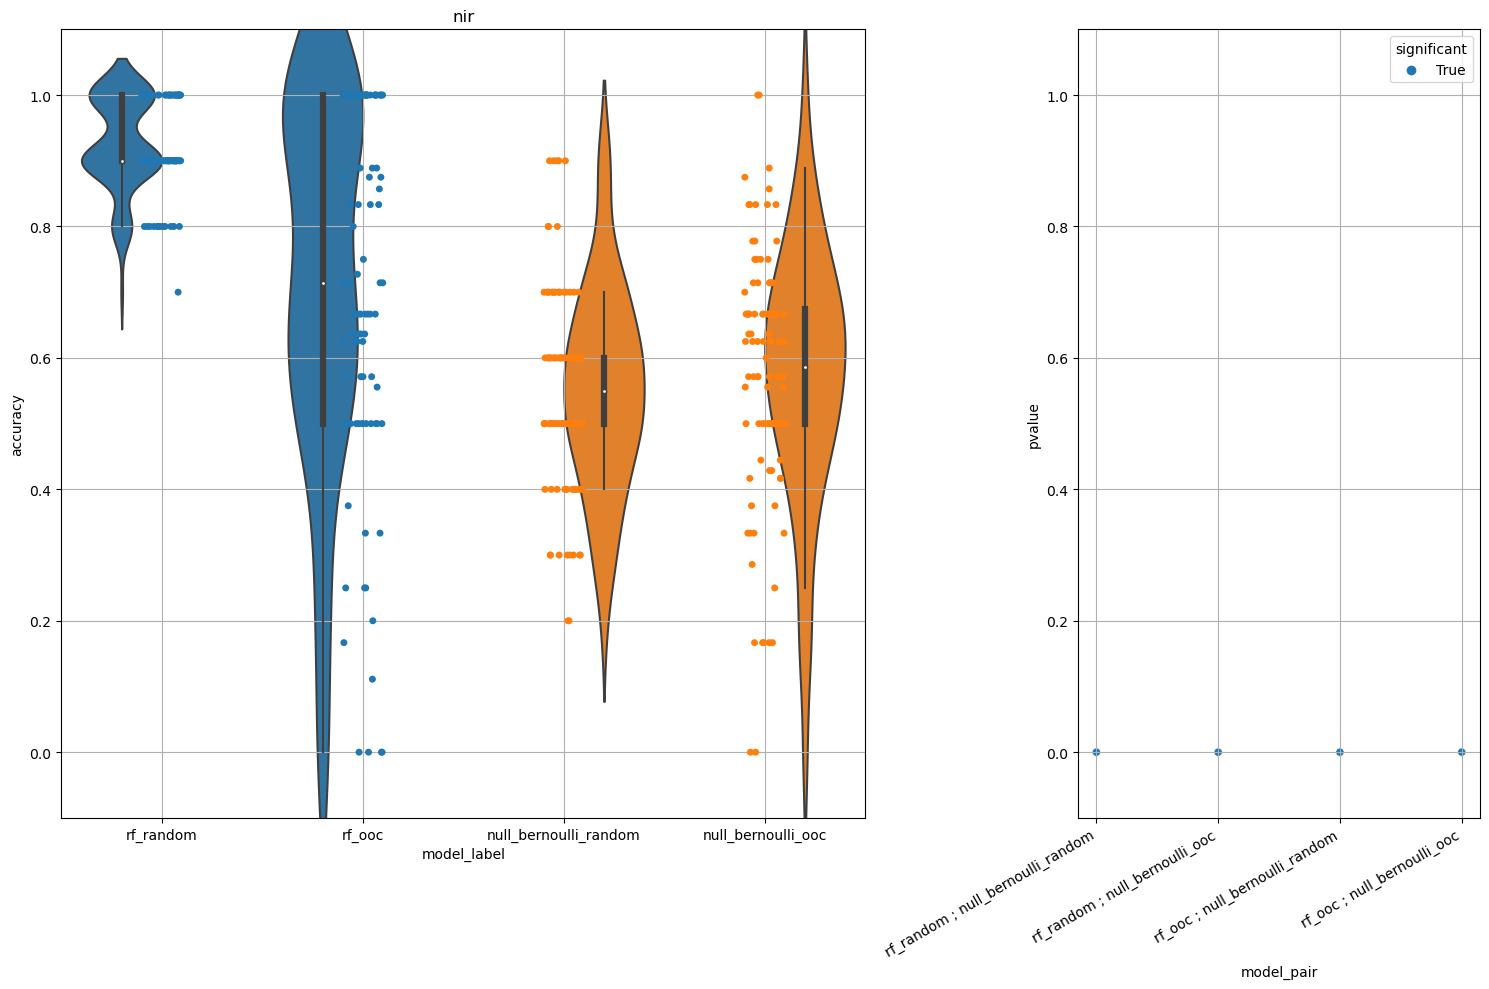

In [ ]:
plot_model_comparison({'rf_random':results_rf_random,'null_bernoulli_random':results_bernoulli_random,'rf_ooc':results_rf_ooc,'null_bernoulli_ooc':results_bernoulli_ooc},carbons=['nir'],p_pairs=None,figsize=(15,10))

OOC prediction for NIR is significant. 

### Feature importance of actual DN genes? 

In [ ]:
dn_genes="narG,K00370;napA,K02567;nirS,K15864;nirK,K00368;qNor,K04561;nosZ,K00376;narX,K07673;dnr,K21563;nnrR,K21564;norR,K12266;nnrS,K07234;nsrR,K13771;narK1,K02575;narK2,K02575;narK1K2,K02575"
dn_genes=pd.Series({line.split(',')[0]:line.split(',')[1] for line in dn_genes.split(";")})

<AxesSubplot: >

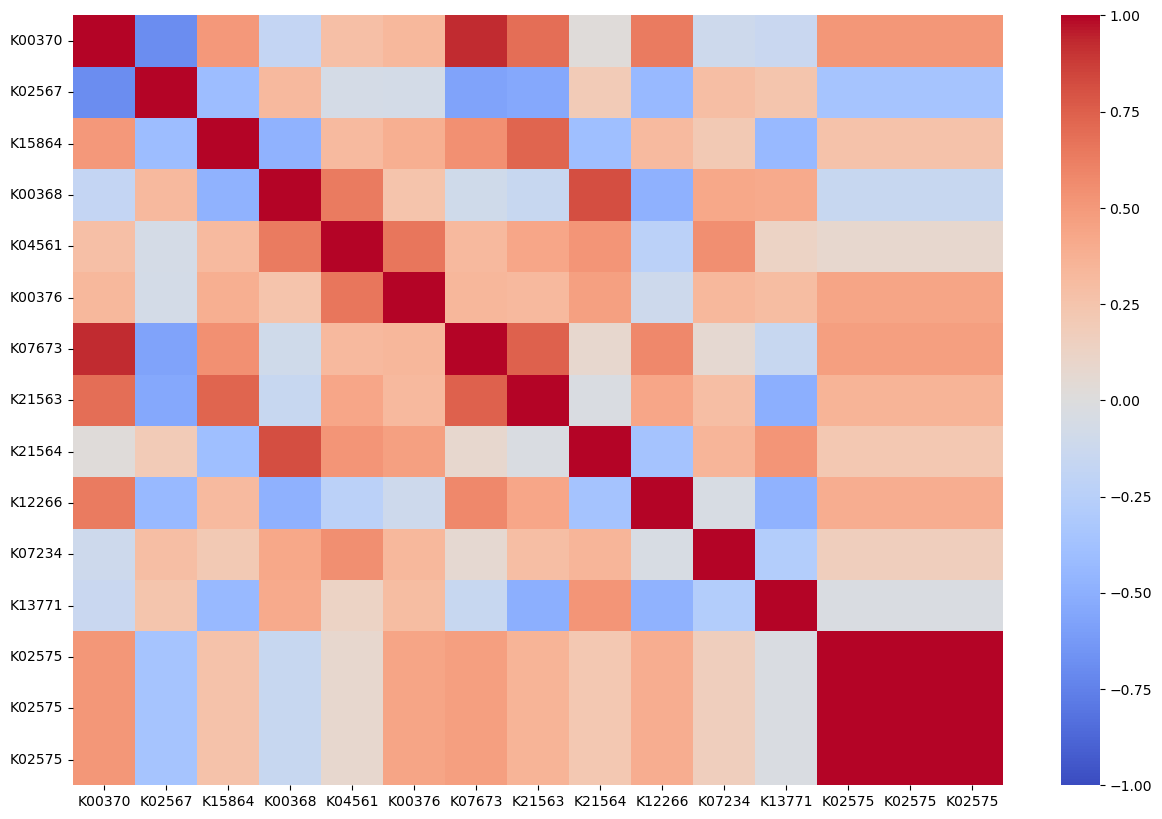

In [ ]:
sns.heatmap(kos_data[dn_genes.values].corr(),vmin=-1,vmax=1,cmap='coolwarm')

<AxesSubplot: ylabel='sample'>

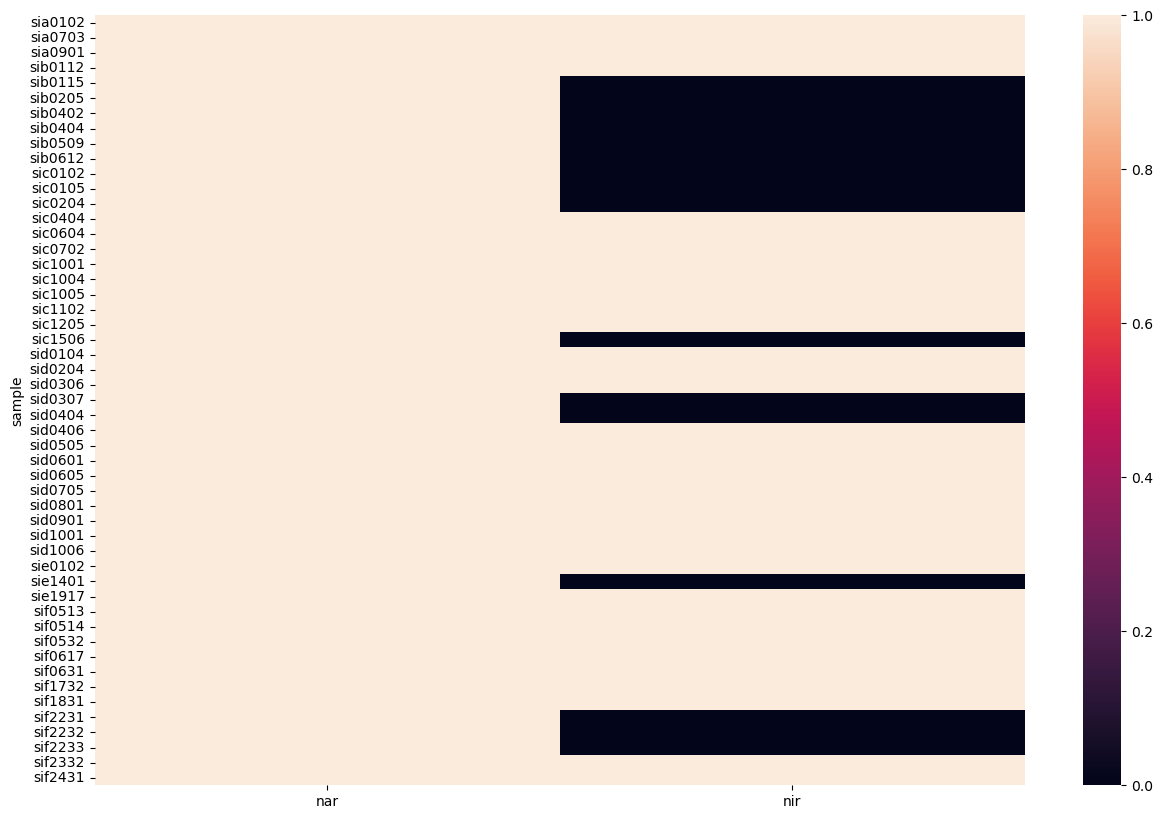

In [ ]:
sns.heatmap(dn)

<AxesSubplot: >

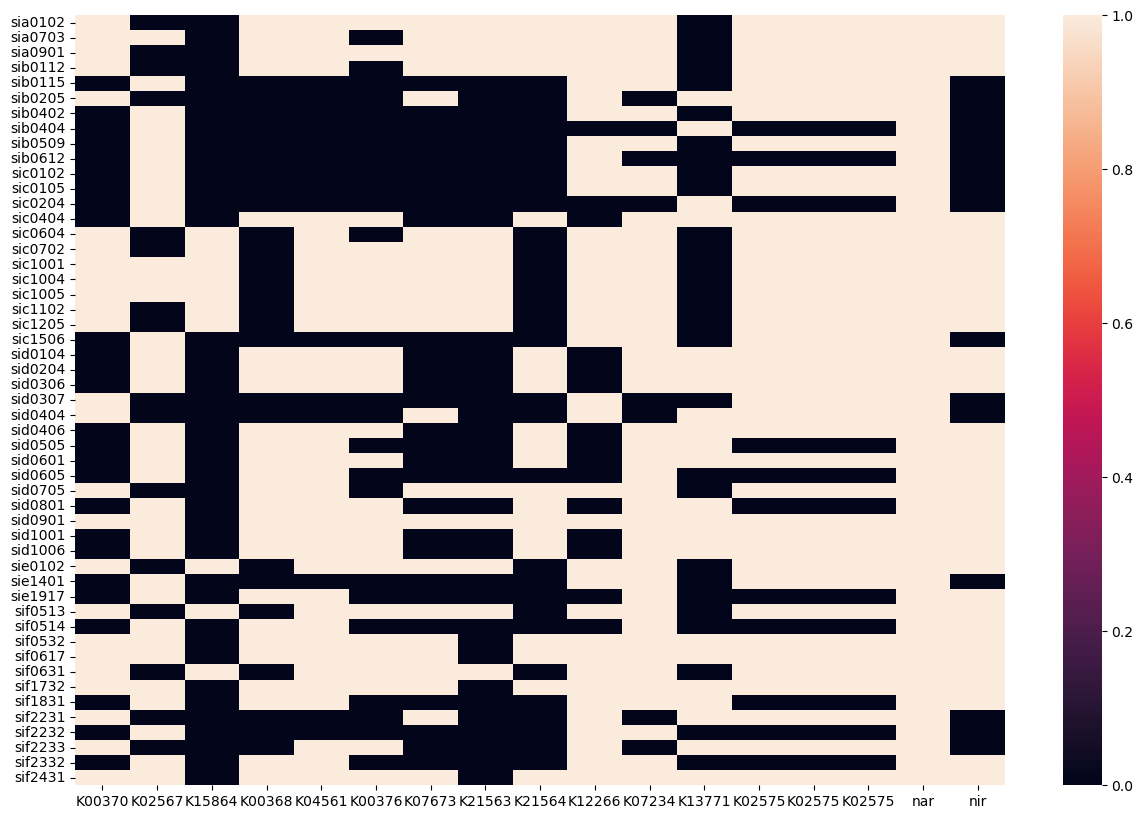

In [ ]:
sns.heatmap(pd.concat([kos_data[dn_genes.values],dn],axis=1))

In [ ]:
dn_genes

narG       K00370
napA       K02567
nirS       K15864
nirK       K00368
qNor       K04561
nosZ       K00376
narX       K07673
dnr        K21563
nnrR       K21564
norR       K12266
nnrS       K07234
nsrR       K13771
narK1      K02575
narK2      K02575
narK1K2    K02575
dtype: object

In [ ]:
def cal_feature_importance(results, kos_data, mechanism,trim=100):
    df_fi=[]
    for c, group in results.groupby('carbon_name'):
        arr_fis=np.array(list(group['feature_importances'].values))
        features=kos_data.columns
        df=pd.DataFrame({'features':features, 'carbon_name':[c]*len(features), 'fi_mean':arr_fis.mean(axis=0), 'fi_std':arr_fis.std(axis=0)})
        df['is_true_feature']=df['features'].isin(mechanism).astype(int)
        if trim and trim<df.shape[0]:
            df=df.sort_values('fi_mean', ascending=False).iloc[:trim]
        df_fi.append(df.reset_index())
    
    df_fi=pd.concat(df_fi,axis=0,ignore_index=True)
    return df_fi

In [ ]:
cal_feature_importance(results_rf_random, kos_data, dn_genes.values,trim=100)
df_fi[df_fi['is_true_feature']==1]

,index,features,carbon_name,fi_mean,fi_std,is_true_feature
0,2298,K04561,nir,0.019501,0.010873,1
12,3059,K07234,nir,0.005904,0.005576,1
16,213,K00368,nir,0.005123,0.004992,1
21,220,K00376,nir,0.004191,0.005368,1
43,5820,K21563,nir,0.002792,0.003818,1
66,3268,K07673,nir,0.002187,0.003471,1


In [ ]:
df_fi=cal_feature_importance(results_rf_ooc, kos_data, dn_genes.values,trim=100)
df_fi[df_fi['is_true_feature']==1]

,index,features,carbon_name,fi_mean,fi_std,is_true_feature
0,2298,K04561,nir,0.019501,0.010873,1
12,3059,K07234,nir,0.005904,0.005576,1
16,213,K00368,nir,0.005123,0.004992,1
21,220,K00376,nir,0.004191,0.005368,1
43,5820,K21563,nir,0.002792,0.003818,1
66,3268,K07673,nir,0.002187,0.003471,1


In [ ]:
kos_data.shape

(51, 6393)

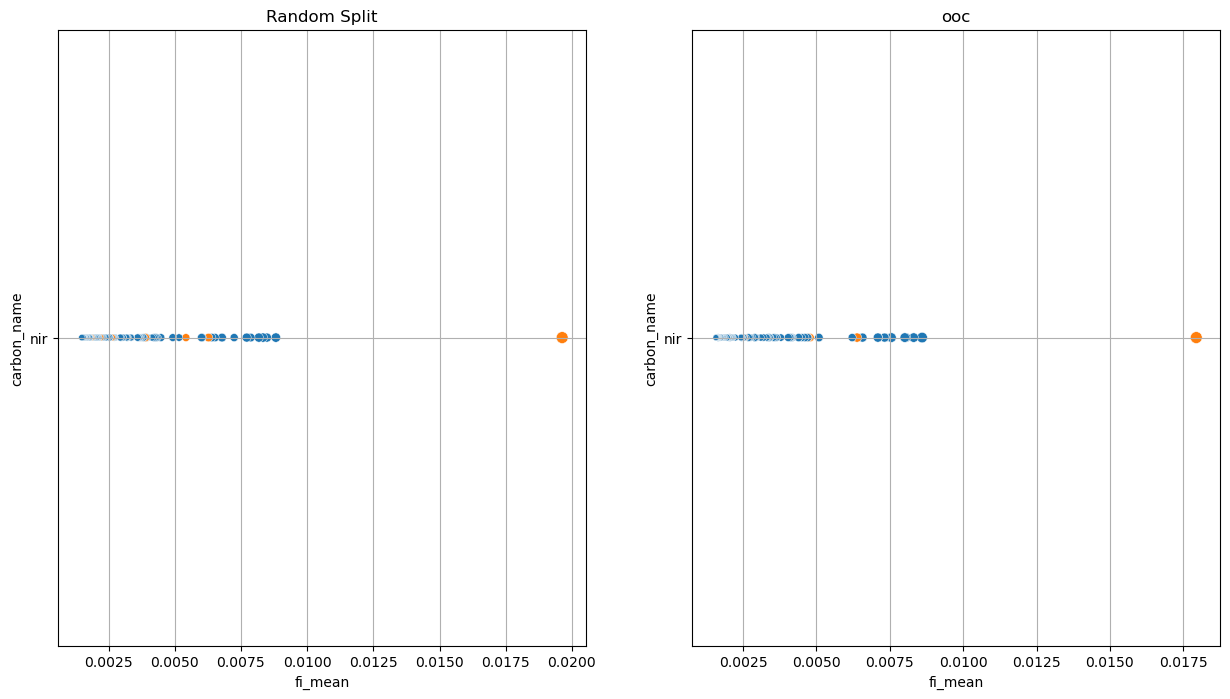

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(15,8))

sns.scatterplot(data=cal_feature_importance(results_rf_random, kos_data, dn_genes.values,trim=100), x='fi_mean',y='carbon_name', hue='is_true_feature', size='fi_std',legend=False,ax=axes[0])
axes[0].set_title('Random Split')
axes[0].grid()

sns.scatterplot(data=cal_feature_importance(results_rf_ooc, kos_data, dn_genes.values,trim=100), x='fi_mean',y='carbon_name', hue='is_true_feature', size='fi_std',legend=False,ax=axes[1])
axes[1].set_title('ooc')
axes[1].grid()

NameError: name 'ffs' is not defined

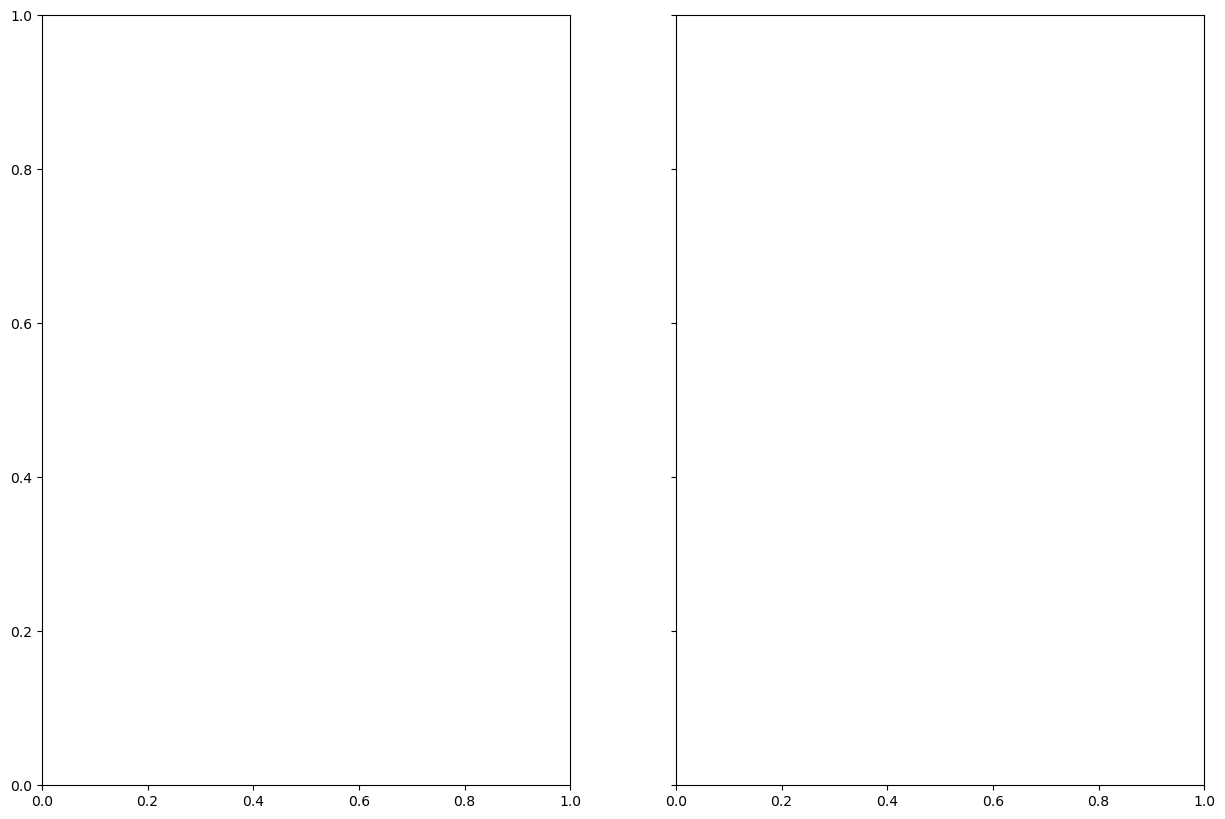

In [ ]:

fig, axes=plt.subplots(1,2, figsize=(15,10),sharey=True)

for ff,ax in tqdm(zip(ffs,np.array(axes).flatten())):
    df_fi=cal_feature_importance(all_data[ff], data_raw['kos_data'],data_raw['mechanism'],trim=100)
    sns.scatterplot(data=df_fi, x='fi_mean',y='carbon_name', hue='is_true_feature', size='fi_std',ax=ax,legend=False)
    ax.grid()
    ax.set_title(ff)

plt.tight_layout()
